<a href="https://colab.research.google.com/github/ganys88/DataScienceBootCamp/blob/main/Capstone_FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_tele = pd.read_csv('/content/drive/MyDrive/archive (1)/PdM_telemetry.csv')
df_tele['datetime'] = pd.to_datetime(df_tele['datetime'])
df_tele.head(3)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847


In [ ]:
df_tele.shape

(876100, 6)

In [ ]:
#Is auto correlation present?

#What is auto-correlation?
#In time series data, it means how much today's value is related to the value from previous days/hours.

1. Visual test (ACF and PACF plots)
2. Statistical test ( Ljung-Box test)

In [ ]:
#taking a small sample to perform auto-correlation test

df_samp = df_tele.iloc[:10000]
#df_samp = df_tele.iloc[:900]

In [ ]:
#Time-Series Analysis: set datetime as index (required for time series analysis)
df_samp.set_index('datetime', inplace=True)

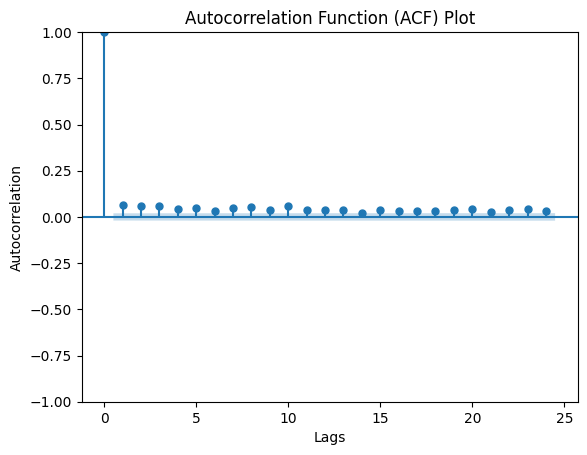

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


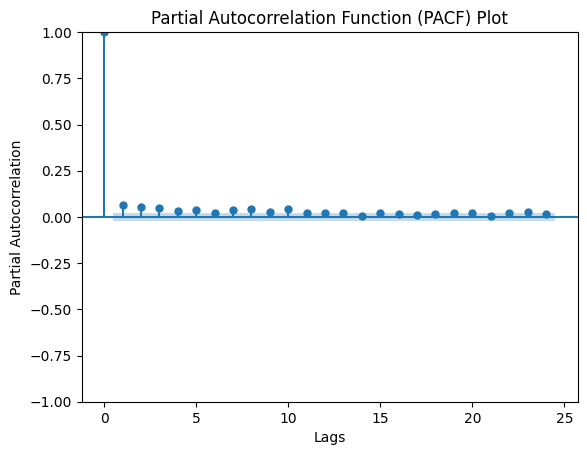

In [ ]:
#visual test (If the lines are longer and closer to 1, AC is present. If lines are shorter, AC absent)
import statsmodels.api as sm
import matplotlib.pyplot as plt

variable = df_samp['volt'] #check for vibrate, rotate, and pressure also
# Create ACF plot
sm.graphics.tsa.plot_acf(variable, lags=24, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

# Create PACF plot
sm.graphics.tsa.plot_pacf(variable, lags=24, alpha=0.05)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()

#conclusion
#The visual test for all variables indicate auto-correlation is absent (meaning: current value not affected by previous values)

In [ ]:
#statistical-test

# Select the 'volt' feature from the DataFrame
var = df_samp['vibration'] #check with volt, rotate, and pressure too.

# Perform Ljung-Box test
lags_to_check = 24  # You can choose the number of lags to consider
test_results = sm.stats.acorr_ljungbox(var, lags=lags_to_check, return_df=True)

# Get the p-values from the test results
p_values = test_results['lb_pvalue']

# Check if any p-value is below the significance level (e.g., 0.05)
significant_autocorr = any(p_values < 0.05)

print(p_values)

if significant_autocorr:
    print("Autocorrelation is present.")
else:
    print("No significant autocorrelation.")

#conclusion:
#If test is done with larger sample, autocorrelation is present (meaning current values are affected by previous values)
#If test is done with smaller sample, autocorrelation is ABSENT (rotate and pressure) & Present (volt and pressure)

#Note: using larger sample makes Ljung-Box test more sensitive (meaning it detects very very small autocorrelation too)
#So, we check autocorrelation with smaller sample to add more robustness to our decision

#Decision:
#No auto-correlation in rotate and pressure
#Small auto-correlation suspected in volt and vibration

1      1.148082e-50
2     6.550885e-105
3     3.536828e-157
4     2.626514e-202
5     6.418136e-247
6     2.799543e-290
7      0.000000e+00
8      0.000000e+00
9      0.000000e+00
10     0.000000e+00
11     0.000000e+00
12     0.000000e+00
13     0.000000e+00
14     0.000000e+00
15     0.000000e+00
16     0.000000e+00
17     0.000000e+00
18     0.000000e+00
19     0.000000e+00
20     0.000000e+00
21     0.000000e+00
22     0.000000e+00
23     0.000000e+00
24     0.000000e+00
Name: lb_pvalue, dtype: float64
Autocorrelation is present.


**Is Auto-correlation present?**

1. Visual test says NO
2. Statistical test says YES (for volt and vibration)

Therefore, we suspect auto-correlation in volt and vibration
And, deny auto-correlation in pressure and rotate

***What is the implication of suspected auto-correlation?***

=> We will create lag variables for volt and vibration



**What is lag variable?**

lag=1 means, we simply shift volt column downward by 1 step.
(Because we suspect volt from previous hour might affect failure at current hour)

In [ ]:
# Create lag features for 'volt' and 'vibration' with 1-hour lag
df_tele['volt_lag_1'] = df_tele['volt'].shift(1)
df_tele['vibration_lag_1'] = df_tele['vibration'].shift(1)

# Create lag features for 'volt' and 'vibration' with 24-hour lag (daily lag)
df_tele['volt_lag_24'] = df_tele['volt'].shift(24)
df_tele['vibration_lag_24'] = df_tele['vibration'].shift(24)

Lag variables might not be reliable for prediction.
Why? because we are not so sure about presence of auto-correlation

So What?
We opt for another method of time-series feature engineering.
ROLLING VARIABLES

**What are rolling variables?**

1. Three types: Rolling mean, rolling max and rolling mean

2. Rolling variables have sth called window (which is time period, example 3 hours)

3. rolling mean (aka moving average) = mean of last 3 hours (window = 3hrs)


In [ ]:
#Mathematically
#RMean(t) = (X(t) + X(t-1) + X(t-2) + ... + X(t-k+1)) / k ()
#RMin(t) = min(X(t), X(t-1), X(t-2), ..., X(t-k+1))

In [ ]:
#Rolling variables
#Advantage of rolling variables: instead of volt,pressure, vibration and rotate, we can use rolling variables.
#Why? because they capture the trend from past few hours or a day

In [ ]:
#volt
# Create a 3-hour rolling window variable
df_tele['volt_rolling_3h'] = df_tele['volt'].rolling(window=3).mean() #mean of last 3 hours
df_tele['volt_rolling_min_3h'] = df_tele['volt'].rolling(window=3).min() #minimum of last 3 hours
df_tele['volt_rolling_max_3h'] = df_tele['volt'].rolling(window=3).max() #max of last 3 hours

# Create a 24-hour rolling window variable
df_tele['volt_rolling_24h'] = df_tele['volt'].rolling(window=24).mean() #mean of the day
df_tele['volt_rolling_min_24h'] = df_tele['volt'].rolling(window=24).min() #min of the day
df_tele['volt_rolling_max_24h'] = df_tele['volt'].rolling(window=24).max() #max of the day

In [ ]:
#rotate
#df_tele['rotate_rolling_3h'] = df_tele['rotate'].rolling(window=3).mean()
df_tele['rotate_rolling_min_3h'] = df_tele['rotate'].rolling(window=3).min()
df_tele['rotate_rolling_max_3h'] = df_tele['rotate'].rolling(window=3).max()

# Create a 24-hour rolling window variable
df_tele['rotate_rolling_24h'] = df_tele['rotate'].rolling(window=24).mean()
df_tele['rotate_rolling_min_24h'] = df_tele['rotate'].rolling(window=24).min()
df_tele['rotate_rolling_max_24h'] = df_tele['rotate'].rolling(window=24).max()

In [ ]:
#pressure
# Create a 3-hour rolling window variable
df_tele['pressure_rolling_3h'] = df_tele['pressure'].rolling(window=3).mean()
df_tele['pressure_rolling_min_3h'] = df_tele['pressure'].rolling(window=3).min()
df_tele['pressure_rolling_max_3h'] = df_tele['pressure'].rolling(window=3).max()

# Create a 24-hour rolling window variable
df_tele['pressure_rolling_24h'] = df_tele['pressure'].rolling(window=24).mean()
df_tele['pressure_rolling_min_24h'] = df_tele['pressure'].rolling(window=24).min()
df_tele['pressure_rolling_max_24h'] = df_tele['pressure'].rolling(window=24).max()

In [ ]:
#vibration
# Create a 3-hour rolling window variable
df_tele['vibration_rolling_3h'] = df_tele['vibration'].rolling(window=3).mean()
df_tele['vibration_rolling_min_3h'] = df_tele['vibration'].rolling(window=3).min()
df_tele['vibration_rolling_max_3h'] = df_tele['vibration'].rolling(window=3).max()

# Create a 24-hour rolling window variable
df_tele['vibration_rolling_24h'] = df_tele['vibration'].rolling(window=24).mean()
df_tele['vibration_rolling_min_24h'] = df_tele['vibration'].rolling(window=24).min()
df_tele['vibration_rolling_max_24h'] = df_tele['vibration'].rolling(window=24).max()

In [ ]:
df_tele
#conclusion:
#df_tele contains 2 new lag variables and multiple rolling variables that we will use as features in the model

,datetime,machineID,volt,rotate,pressure,vibration,volt_lag_1,vibration_lag_1,volt_lag_24,vibration_lag_24,...,pressure_rolling_max_3h,pressure_rolling_24h,pressure_rolling_min_24h,pressure_rolling_max_24h,vibration_rolling_3h,vibration_rolling_min_3h,vibration_rolling_max_3h,vibration_rolling_24h,vibration_rolling_min_24h,vibration_rolling_max_24h
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,176.217853,45.087686,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,162.879223,43.413973,NaN,NaN,...,113.077935,NaN,NaN,NaN,40.893502,34.178847,45.087686,NaN,NaN,NaN
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,170.989902,34.178847,NaN,NaN,...,109.248561,NaN,NaN,NaN,39.571655,34.178847,43.413973,NaN,NaN,NaN
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,162.462833,41.122144,NaN,NaN,...,111.886648,NaN,NaN,NaN,33.763834,25.990511,41.122144,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,162.742669,44.382754,148.126516,37.983313,...,103.158233,101.414987,79.584958,117.42634,47.481232,44.382754,50.771941,39.955780,27.457001,50.83221
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,179.438162,50.771941,136.363542,34.923653,...,102.290715,101.396728,79.584958,117.42634,43.425922,35.123072,50.771941,39.964090,27.457001,50.83221
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,189.617555,35.123072,169.925104,37.362718,...,102.290715,101.020326,79.584958,117.42634,44.736524,35.123072,50.771941,40.420416,27.457001,50.83221
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,192.483414,48.314561,163.234778,48.646624,...,104.081073,101.447889,79.584958,117.42634,42.757630,35.123072,48.314561,40.261609,27.457001,50.83221


In [ ]:
df_tele.shape[0]

876100

Task 1: Create a dataframe of proactive maintenance

How? All maintenance data - Reactive maintenance

In [ ]:
#Load Failure and maintenance data
df_fail = pd.read_csv("/content/drive/MyDrive/archive (1)/PdM_failures.csv")
df_maint = pd.read_csv('/content/drive/MyDrive/archive (1)/PdM_maint.csv')

In [ ]:
#convert to pandas datetime
df_maint['datetime'] = pd.to_datetime(df_maint['datetime'])
df_fail['datetime'] = pd.to_datetime(df_fail['datetime'])

In [ ]:
#remove observations before 2015 from maintenance data
start_datetime = pd.to_datetime('2015-01-01 06:00:00')
end_datetime = pd.to_datetime('2016-01-01 06:00:00')

# Subset 'df_maint' based on the specified datetime range
df_maint = df_maint[(df_maint['datetime'] >= start_datetime) & (df_maint['datetime'] <= end_datetime)]

#check dates of maintenance
df_maint['datetime'].min()

Timestamp('2015-01-01 06:00:00')

In [ ]:
#check dates of failure
df_fail['datetime'].max()
#df_fail['datetime'].min()

Timestamp('2015-12-31 06:00:00')

In [ ]:
# Use the 'rename()' method to rename the 'failure' column to 'comp'
df_fail.rename(columns={'failure': 'comp'}, inplace=True)

In [ ]:
# Perform the left join
df_pro_maint = pd.merge(df_maint, df_fail, on=['machineID', 'datetime', 'comp'], how='left', indicator=True)

# Filter the rows where the key is not present in the right DataFrame (antileft join)
df_pro_maint= df_pro_maint[df_pro_maint['_merge'] == 'left_only']
df_pro_maint.drop(columns='_merge', inplace=True)

#df_maint2 contains proactive maintenance data
df_pro_maint.shape[0]

#df_pro_maint contains all proactive maintenance data
#Task 1 completed

2143

In [ ]:
df_fail.rename(columns={'comp': 'failure'}, inplace=True)

In [ ]:
df_pro_maint

,datetime,machineID,comp
1,2015-01-05 06:00:00,1,comp1
2,2015-01-20 06:00:00,1,comp3
3,2015-01-20 06:00:00,1,comp1
4,2015-02-04 06:00:00,1,comp4
5,2015-02-04 06:00:00,1,comp3
...,...,...,...
2880,2015-10-10 06:00:00,100,comp1
2881,2015-10-10 06:00:00,100,comp3
2882,2015-10-25 06:00:00,100,comp4
2883,2015-11-09 06:00:00,100,comp4


Task 2: Merge failure(reactive maintenance) and proactive maintenance data into telemetry data

In [ ]:
diff = df_maint.shape[0] - df_fail.shape[0]
print(df_maint.shape[0])
print(df_fail.shape[0])
print(diff)

2886
761
2125


In [ ]:
#Note: 18 observations in df_fail are not present in df_maint.
#So, Math looks like this.
#proactive maintenance = 2886 - 743 = 2143

In [ ]:
#df_fail (761 reactive maintenance observations)
#df_main (2143 proactive maintenance observations)
#df_tele (876100 all observations)

In [ ]:
df_fail

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
...,...,...,...
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1


In [ ]:
#merge failure and telemetry data
df_tele_fail = pd.merge(df_tele, df_fail, on=['machineID', 'datetime'], how='left')

#fill non-matching columns by 'no'
df_tele_fail['failure'] = df_tele_fail['failure'].fillna('no')

In [ ]:
df_tele_fail

,datetime,machineID,volt,rotate,pressure,vibration,volt_lag_1,vibration_lag_1,volt_lag_24,vibration_lag_24,...,pressure_rolling_24h,pressure_rolling_min_24h,pressure_rolling_max_24h,vibration_rolling_3h,vibration_rolling_min_3h,vibration_rolling_max_3h,vibration_rolling_24h,vibration_rolling_min_24h,vibration_rolling_max_24h,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,176.217853,45.087686,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,162.879223,43.413973,NaN,NaN,...,NaN,NaN,NaN,40.893502,34.178847,45.087686,NaN,NaN,NaN,no
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,170.989902,34.178847,NaN,NaN,...,NaN,NaN,NaN,39.571655,34.178847,43.413973,NaN,NaN,NaN,no
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,162.462833,41.122144,NaN,NaN,...,NaN,NaN,NaN,33.763834,25.990511,41.122144,NaN,NaN,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876137,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,162.742669,44.382754,148.126516,37.983313,...,101.414987,79.584958,117.42634,47.481232,44.382754,50.771941,39.955780,27.457001,50.83221,no
876138,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,179.438162,50.771941,136.363542,34.923653,...,101.396728,79.584958,117.42634,43.425922,35.123072,50.771941,39.964090,27.457001,50.83221,no
876139,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,189.617555,35.123072,169.925104,37.362718,...,101.020326,79.584958,117.42634,44.736524,35.123072,50.771941,40.420416,27.457001,50.83221,no
876140,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,192.483414,48.314561,163.234778,48.646624,...,101.447889,79.584958,117.42634,42.757630,35.123072,48.314561,40.261609,27.457001,50.83221,no


In [ ]:
#potential dependent variable
df_tele_fail['failure'].value_counts()

no       875381
comp2       259
comp1       192
comp4       179
comp3       131
Name: failure, dtype: int64

In [ ]:
#merge telemetry & failure data with proactive maintenance data
df_tele_fail_pm = pd.merge(df_tele_fail, df_pro_maint, on=['machineID', 'datetime'], how='left')
df_tele_fail_pm['comp'] = df_tele_fail_pm['comp'].fillna(0)

In [ ]:
df_tele_fail_pm['comp'].value_counts()

0        874402
comp3       580
comp4       535
comp1       521
comp2       507
Name: comp, dtype: int64

In [ ]:
# Create dummy variables of 4 components (proactive maintenance)
dummy_variables = pd.get_dummies(df_tele_fail_pm['comp'], prefix= 'pm')

# Add the dummy variables to the df_maint DataFrame
df_tele_fail_pm = pd.concat([df_tele_fail_pm , dummy_variables], axis=1)

In [ ]:
df_tele_fail_pm

,datetime,machineID,volt,rotate,pressure,vibration,volt_lag_1,vibration_lag_1,volt_lag_24,vibration_lag_24,...,vibration_rolling_24h,vibration_rolling_min_24h,vibration_rolling_max_24h,failure,comp,pm_0,pm_comp1,pm_comp2,pm_comp3,pm_comp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,no,0,1,0,0,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,176.217853,45.087686,NaN,NaN,...,NaN,NaN,NaN,no,0,1,0,0,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,162.879223,43.413973,NaN,NaN,...,NaN,NaN,NaN,no,0,1,0,0,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,170.989902,34.178847,NaN,NaN,...,NaN,NaN,NaN,no,0,1,0,0,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,162.462833,41.122144,NaN,NaN,...,NaN,NaN,NaN,no,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876540,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,162.742669,44.382754,148.126516,37.983313,...,39.955780,27.457001,50.83221,no,0,1,0,0,0,0
876541,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,179.438162,50.771941,136.363542,34.923653,...,39.964090,27.457001,50.83221,no,0,1,0,0,0,0
876542,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,189.617555,35.123072,169.925104,37.362718,...,40.420416,27.457001,50.83221,no,0,1,0,0,0,0
876543,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,192.483414,48.314561,163.234778,48.646624,...,40.261609,27.457001,50.83221,no,0,1,0,0,0,0


Task 3: Create a new variable: Hours after maintenance

Which records number of hours since last maintenance of that specific component of the specific machine

In [ ]:
#Hours after maintenance (ham) for component1

# Create a list to store the 'df_tele_fail_pm' values
df_tele_fail_pm_values = []

# Iterate through the DataFrame grouped by 'machineID' to calculate the 'df_tele_fail_pm' values
for _, group in df_tele_fail_pm.groupby('machineID'):
    # Initialize a variable to store the cumulative sum for each machineID group
    cumulative_sum = 0

    # Iterate through the 'pm_comp1' column for the current 'machineID' group
    for pm_value in group['pm_comp1']:
        if pm_value == 1:
            df_tele_fail_pm_values.append(0)
            cumulative_sum = 0
        else:
            cumulative_sum += 1
            df_tele_fail_pm_values.append(cumulative_sum)

# Add the 'df_tele_fail_pm' column to the DataFrame
df_tele_fail_pm['ham_comp1'] = df_tele_fail_pm_values

In [ ]:
#Hours after maintenance (ham) for component2

#Create a list to store the 'df_tele_fail_pm' values
df_tele_fail_pm_values = []

# Iterate through the DataFrame grouped by 'machineID' to calculate the 'df_tele_fail_pm' values
for _, group in df_tele_fail_pm.groupby('machineID'):
    # Initialize a variable to store the cumulative sum for each machineID group
    cumulative_sum = 0

    # Iterate through the 'pm_comp2' column for the current 'machineID' group
    for pm_value in group['pm_comp2']:
        if pm_value == 1:
            df_tele_fail_pm_values.append(0)
            cumulative_sum = 0
        else:
            cumulative_sum += 1
            df_tele_fail_pm_values.append(cumulative_sum)

# Add the 'df_tele_fail_pm' column to the DataFrame
df_tele_fail_pm['ham_comp2'] = df_tele_fail_pm_values

In [ ]:
#Hours after maintenance (ham) for component3

# Create a list to store the 'df_tele_fail_pm' values
df_tele_fail_pm_values = []

# Iterate through the DataFrame grouped by 'machineID' to calculate the 'df_tele_fail_pm' values
for _, group in df_tele_fail_pm.groupby('machineID'):
    # Initialize a variable to store the cumulative sum for each machineID group
    cumulative_sum = 0

    # Iterate through the 'pm_comp3' column for the current 'machineID' group
    for pm_value in group['pm_comp3']:
        if pm_value == 1:
            df_tele_fail_pm_values.append(0)
            cumulative_sum = 0
        else:
            cumulative_sum += 1
            df_tele_fail_pm_values.append(cumulative_sum)

# Add the 'df_tele_fail_pm' column to the DataFrame
df_tele_fail_pm['ham_comp3'] = df_tele_fail_pm_values

In [ ]:
#Hours after maintenance (ham) for component4

# Create a list to store the 'df_tele_fail_pm' values
df_tele_fail_pm_values = []

# Iterate through the DataFrame grouped by 'machineID' to calculate the 'df_tele_fail_pm' values
for _, group in df_tele_fail_pm.groupby('machineID'):
    # Initialize a variable to store the cumulative sum for each machineID group
    cumulative_sum = 0

    # Iterate through the 'pm_comp2' column for the current 'machineID' group
    for pm_value in group['pm_comp4']:
        if pm_value == 1:
            df_tele_fail_pm_values.append(0)
            cumulative_sum = 0
        else:
            cumulative_sum += 1
            df_tele_fail_pm_values.append(cumulative_sum)

# Add the 'df_tele_fail_pm' column to the DataFrame
df_tele_fail_pm['ham_comp4'] = df_tele_fail_pm_values

In [ ]:
df_tele_fail_pm

,datetime,machineID,volt,rotate,pressure,vibration,volt_lag_1,vibration_lag_1,volt_lag_24,vibration_lag_24,...,comp,pm_0,pm_comp1,pm_comp2,pm_comp3,pm_comp4,ham_comp1,ham_comp2,ham_comp3,ham_comp4
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,1,1,1,1
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,176.217853,45.087686,NaN,NaN,...,0,1,0,0,0,0,2,2,2,2
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,162.879223,43.413973,NaN,NaN,...,0,1,0,0,0,0,3,3,3,3
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,170.989902,34.178847,NaN,NaN,...,0,1,0,0,0,0,4,4,4,4
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,162.462833,41.122144,NaN,NaN,...,0,1,0,0,0,0,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876540,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,162.742669,44.382754,148.126516,37.983313,...,0,1,0,0,0,0,1989,188,1988,1268
876541,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,179.438162,50.771941,136.363542,34.923653,...,0,1,0,0,0,0,1990,189,1989,1269
876542,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,189.617555,35.123072,169.925104,37.362718,...,0,1,0,0,0,0,1991,190,1990,1270
876543,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,192.483414,48.314561,163.234778,48.646624,...,0,1,0,0,0,0,1992,191,1991,1271


In [ ]:
#validate ham
subset_df = df_tele_fail_pm[(df_tele_fail_pm['machineID'] == 1) & (df_tele_fail_pm['pm_comp1'] == 1)]

In [ ]:
#The final data
df = df_tele_fail_pm

In [ ]:
df.drop(columns=['comp', 'pm_0'], inplace=True)

In [ ]:
df.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'volt_lag_1', 'vibration_lag_1', 'volt_lag_24', 'vibration_lag_24',
       'volt_rolling_3h', 'volt_rolling_min_3h', 'volt_rolling_max_3h',
       'volt_rolling_24h', 'volt_rolling_min_24h', 'volt_rolling_max_24h',
       'rotate_rolling_min_3h', 'rotate_rolling_max_3h', 'rotate_rolling_24h',
       'rotate_rolling_min_24h', 'rotate_rolling_max_24h',
       'pressure_rolling_3h', 'pressure_rolling_min_3h',
       'pressure_rolling_max_3h', 'pressure_rolling_24h',
       'pressure_rolling_min_24h', 'pressure_rolling_max_24h',
       'vibration_rolling_3h', 'vibration_rolling_min_3h',
       'vibration_rolling_max_3h', 'vibration_rolling_24h',
       'vibration_rolling_min_24h', 'vibration_rolling_max_24h', 'failure',
       'pm_comp1', 'pm_comp2', 'pm_comp3', 'pm_comp4', 'ham_comp1',
       'ham_comp2', 'ham_comp3', 'ham_comp4'],
      dtype='object')

In [ ]:
df.to_csv('final_data.csv', index=False)

In [ ]:
from google.colab import files
files.download('final_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>